# Contact

*/ Update July 2018 /*
by Alexis Salas-Burgos PhD

## MDAnalysis 
from https://www.mdanalysis.org

## MDTraj
from http://mdtraj.org

## PyTraj
from https://amber-md.github.io/pytraj/latest/index.html

## Prody
from http://prody.csb.pitt.edu

In [1]:
import MDAnalysis as mda
import mdtraj as mdt
import pytraj as mdp
import prody as pd

/usr/local/anaconda3/envs/bio/lib/python3.6/site-packages/MDAnalysis/due.py:88: UserWarning: No module named 'duecredit'
  warnings.warn(str(err))


In [2]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.switch_backend('agg')

In [3]:
DCD = "tutorial/ubq_wb_eq.dcd"
PSF = "tutorial/ubq_wb.psf"
PDB = "tutorial/ubq_wb.pdb"

In [4]:
# load trajectory
#from MDAnalysis.tests.datafiles import PSF, DCD, PDB
## MDAnalysis
u = mda.Universe(PSF, DCD)
## MDTraj
t = mdt.load(DCD, top=PSF)
## PyTraj
p = mdp.load(DCD, top=PSF)

# Correlation Matrix

In [9]:
%matplotlib inline
from matplotlib import pyplot as plt
import seaborn as sns
mat = mdp.matrix.covar(p, '@CA')
mat

array([[ 0.48689554, -0.15775188, -0.0623335 , ..., -0.21139867,
         0.40017817,  0.25975171],
       [-0.15775188,  3.03649752, -0.13675646, ...,  0.11716326,
         2.37807745,  0.32898291],
       [-0.0623335 , -0.13675646,  0.52575036, ..., -0.40272649,
         0.43718223,  0.47728735],
       ...,
       [-0.21139867,  0.11716326, -0.40272649, ...,  8.04541157,
        -5.17525506, -5.23724063],
       [ 0.40017817,  2.37807745,  0.43718223, ..., -5.17525506,
         8.09363229,  3.86583863],
       [ 0.25975171,  0.32898291,  0.47728735, ..., -5.23724063,
         3.86583863,  4.94698564]])

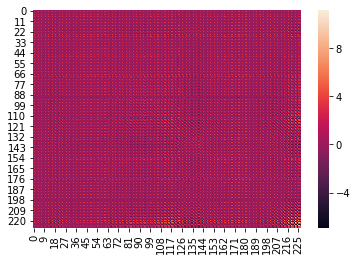

In [10]:
# adapted from: https://stanford.edu/~mwaskom/software/seaborn/examples/many_pairwise_correlations.html
# Set up the matplotlib figure
#f, ax = plt.subplots(figsize=(11, 9))
f, ax = plt.subplots()
## Generate a custom diverging colormap
#cmap = sns.diverging_palette(220, 10, as_cmap=True)
sns.heatmap(mat)
## Draw the heatmap with correct aspect ratio
#sns.heatmap(mat, cmap=cmap, vmax=.3,
#            square=True, xticklabels=5, yticklabels=5,
#            linewidths=.5, cbar_kws={"shrink": .5}, ax=ax)
#plt.savefig('matrix_covar.png')

## Native Contacts
Using the definition from Best, Hummer, and Eaton, "Native contacts determine protein folding mechanisms in atomistic simulations" PNAS (2013)
http://dx.doi.org/10.1073/pnas.1311599110

Number of native contacts 855
average contacts = 0.9794541001319885


[Text(0,0.5,'Q(X)'),
 Text(0.5,0,'frame'),
 Text(0.5,1,'Native Contacts, average = 0.98')]

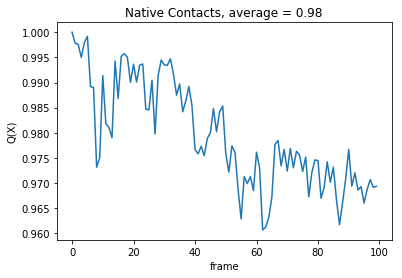

In [5]:
## MDTraj
%matplotlib inline
import numpy as np
import mdtraj as mdt
from itertools import combinations

def best_hummer_q(traj, native):
    """Compute the fraction of native contacts according the definition from
    Best, Hummer and Eaton [1]
    
    Parameters
    ----------
    traj : md.Trajectory
        The trajectory to do the computation for
    native : md.Trajectory
        The 'native state'. This can be an entire trajecory, or just a single frame.
        Only the first conformation is used
        
    Returns
    -------
    q : np.array, shape=(len(traj),)
        The fraction of native contacts in each frame of `traj`
        
    References
    ----------
    ..[1] Best, Hummer, and Eaton, "Native contacts determine protein folding
          mechanisms in atomistic simulations" PNAS (2013)
    """
    
    BETA_CONST = 50  # 1/nm
    LAMBDA_CONST = 1.8
    NATIVE_CUTOFF = 0.45  # nanometers
    
    # get the indices of all of the heavy atoms
    # all, alpha, minimal, heavy, water
    heavy = native.topology.select_atom_indices('heavy')
    # get the pairs of heavy atoms which are farther than 3
    # residues apart
    heavy_pairs = np.array(
        [(i,j) for (i,j) in combinations(heavy, 2)
            if abs(native.topology.atom(i).residue.index - \
                   native.topology.atom(j).residue.index) > 3])
    
    # compute the distances between these pairs in the native state
    heavy_pairs_distances = mdt.compute_distances(native[0], heavy_pairs)[0]
    # and get the pairs s.t. the distance is less than NATIVE_CUTOFF
    native_contacts = heavy_pairs[heavy_pairs_distances < NATIVE_CUTOFF]
    print("Number of native contacts", len(native_contacts))
    
    # now compute these distances for the whole trajectory
    r = mdt.compute_distances(t, native_contacts)
    # and recompute them for just the native state
    r0 = mdt.compute_distances(native[0], native_contacts)
    
    q = np.mean(1.0 / (1 + np.exp(BETA_CONST * (r - LAMBDA_CONST * r0))), axis=1)
    return q

# just for example, use the first frame as the 'native' conformation
q = best_hummer_q(t, t[0])

%matplotlib inline
import matplotlib.pyplot as plt

average_contacts = np.mean(q)
print('average contacts = {}'.format(average_contacts))
# plot time series q(t)
f, ax = plt.subplots()
ax.plot(q)
ax.set(xlabel='frame', ylabel='Q(X)',
       title='Native Contacts, average = {:.2f}'.format(average_contacts))

Number of native contacts = 98
average contacts = 0.48137507430156534


/usr/local/anaconda3/envs/bio/lib/python3.6/site-packages/MDAnalysisTests/__init__.py:119: UserWarning: 
This call to matplotlib.use() has no effect because the backend has already
been chosen; matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

The backend was *originally* set to 'module://ipykernel.pylab.backend_inline' by the following code:
  File "/usr/local/anaconda3/envs/bio/lib/python3.6/runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "/usr/local/anaconda3/envs/bio/lib/python3.6/runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "/usr/local/anaconda3/envs/bio/lib/python3.6/site-packages/ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "/usr/local/anaconda3/envs/bio/lib/python3.6/site-packages/traitlets/config/application.py", line 658, in launch_instance
    app.start()
  File "/usr/local/anaconda3/envs/bio/lib/python3.6/site-pack

[Text(0,0.5,'fraction of native contacts'),
 Text(0.5,0,'frame'),
 Text(0.5,1,'Native Contacts, average = 0.48')]

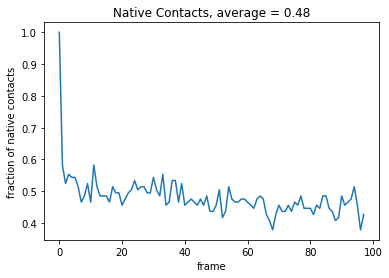

In [6]:
## MDAnalysis
import MDAnalysis as mda
from MDAnalysis.analysis import contacts
from MDAnalysis.tests.datafiles import PSF,DCD
import matplotlib.pyplot as plt

# example trajectory (transition of AdK from closed to open)
u = mda.Universe(PSF,DCD)
# crude definition of salt bridges as contacts between NH/NZ in ARG/LYS and
# OE*/OD* in ASP/GLU. You might want to think a little bit harder about the
# problem before using this for real work.
sel_basic = "(resname ARG LYS) and (name NH* NZ)"
sel_acidic = "(resname ASP GLU) and (name OE* OD*)"
# reference groups (first frame of the trajectory, but you could also use a
# separate PDB, eg crystal structure)
acidic = u.select_atoms(sel_acidic)
basic = u.select_atoms(sel_basic)
# set up analysis of native contacts ("salt bridges"); salt bridges have a
# distance <6 A
ca1 = contacts.Contacts(u, selection=(sel_acidic, sel_basic),
                        refgroup=(acidic, basic), radius=6.0)
# iterate through trajectory and perform analysis of "native contacts" Q
ca1.run()
# print number of averave contacts
average_contacts = np.mean(ca1.timeseries[:, 1])
print('Number of native contacts = {}'.format(len(ca1.timeseries[:, 1])))
print('average contacts = {}'.format(average_contacts))
# plot time series q(t)
f, ax = plt.subplots()
ax.plot(ca1.timeseries[:, 0], ca1.timeseries[:, 1])
ax.set(xlabel='frame', ylabel='fraction of native contacts',
       title='Native Contacts, average = {:.2f}'.format(average_contacts))

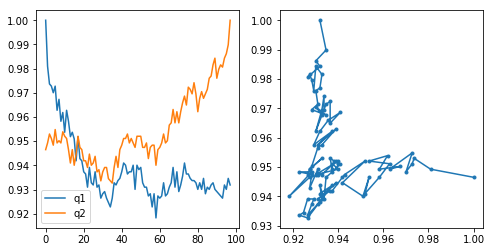

In [7]:
import MDAnalysis as mda
from MDAnalysis.analysis import contacts
from MDAnalysisTests.datafiles import PSF, DCD
u = mda.Universe(PSF, DCD)
q1q2 = contacts.q1q2(u, 'name CA', radius=8)
q1q2.run()

f, ax = plt.subplots(1, 2, figsize=plt.figaspect(0.5))
ax[0].plot(q1q2.timeseries[:, 0], q1q2.timeseries[:, 1], label='q1')
ax[0].plot(q1q2.timeseries[:, 0], q1q2.timeseries[:, 2], label='q2')
ax[0].legend(loc='best')
ax[1].plot(q1q2.timeseries[:, 1], q1q2.timeseries[:, 2], '.-')

[(-0.1, 1.1), Text(0,0.5,'is Bound'), Text(0.5,0,'frame')]

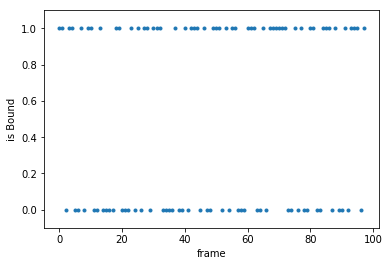

In [8]:
# crude definition of salt bridges as contacts between NH/NZ in ARG/LYS and
# OE*/OD* in ASP/GLU. You might want to think a little bit harder about the
# problem before using this for real work.
def is_any_closer(r, r0, dist=2.5):
    return np.any(r < dist)

sel_basic = "(resname ARG LYS) and (name NH* NZ)"
sel_acidic = "(resname ASP GLU) and (name OE* OD*)"

# reference groups (first frame of the trajectory, but you could also use a
# separate PDB, eg crystal structure)
acidic = u.select_atoms(sel_acidic)
basic = u.select_atoms(sel_basic)

nc = contacts.Contacts(u, selection=(sel_acidic, sel_basic),
                       method=is_any_closer,
                       refgroup=(acidic, basic), kwargs={'dist': 2.5})
nc.run()

bound = nc.timeseries[:, 1]
frames = nc.timeseries[:, 0]

f, ax = plt.subplots()

ax.plot(frames, bound, '.')
ax.set(xlabel='frame', ylabel='is Bound',
       ylim=(-0.1, 1.1))